<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/Surface-Water-Mapping-Landsat8/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install xee -q

In [2]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter

In [3]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

In [6]:
map=geemap.Map(basemap="SATELLITE")
mapmap=geemap.Map(basemap="SATELLITE")
map

In [5]:
start_time = '2024-01-01'
end_time = '2024-12-31'
roi = map.draw_last_feature.geometry()

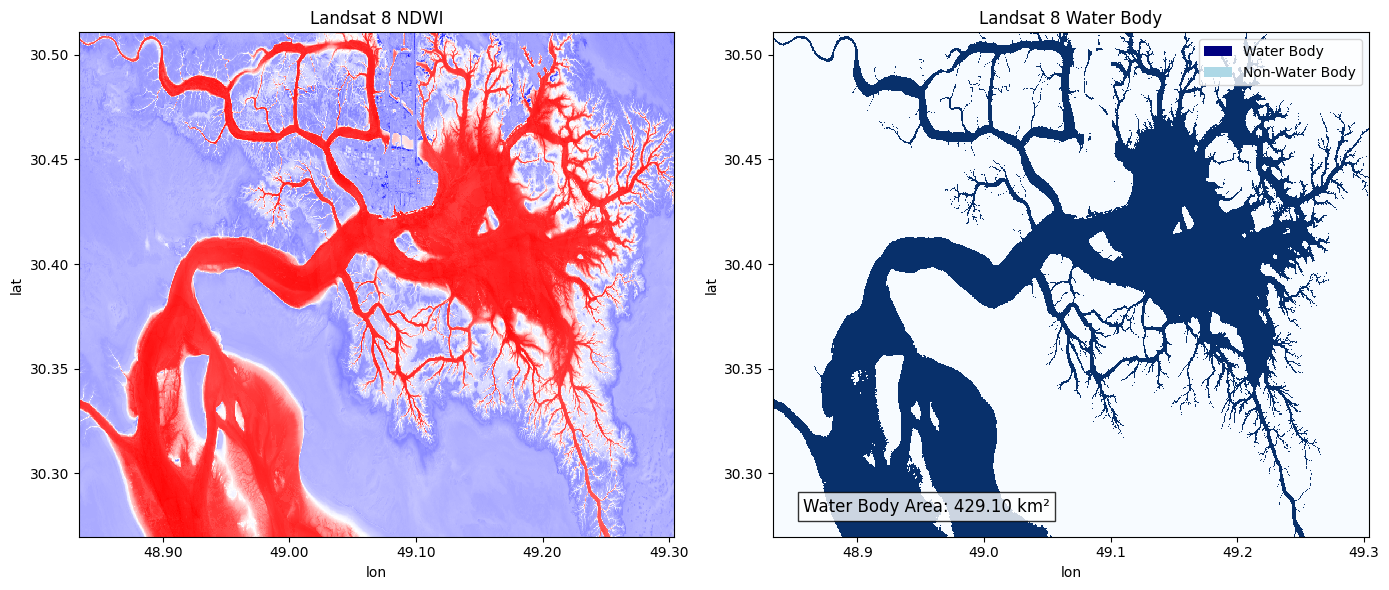

In [6]:
# Load Landsat 8 SR collection
landsat = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(roi)
    .filterDate(start_time, end_time))



def landsat_ndwi(img):
    qa = img.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 3).neq(0)
    cirrus = qa.bitwiseAnd(1 << 2).neq(0)
    shadow = qa.bitwiseAnd(1 << 4).neq(0)
    mask = cloud.Or(cirrus).Or(shadow)
    bands = img.select('SR.*').multiply(2.75e-05).add(-0.2)
    index = bands.normalizedDifference(['SR_B3', 'SR_B5']).rename('ndwi')
    return index.updateMask(mask.Not()).copyProperties(img, img.propertyNames())

landsat_ndwi_col = landsat.map(landsat_ndwi)

# Load as xarray dataset via Earth Engine Python API's open_dataset or similar
ds_landsat = xr.open_dataset(
    landsat_ndwi_col,
    engine='ee',
    crs='EPSG:4326',
    scale=0.000269,  # ~30m in degrees
    geometry=roi
)

ds_landsat_mean = ds_landsat.mean('time')

df_landsat = ds_landsat_mean.to_dataframe().dropna()
model_landsat = KMeans(n_clusters=2, random_state=42)
df_landsat['clustering_raw'] = model_landsat.fit_predict(df_landsat[['ndwi']])
cluster_means_landsat = df_landsat.groupby('clustering_raw')['ndwi'].mean()
water_label_landsat = cluster_means_landsat.idxmax()
df_landsat['clustering'] = (df_landsat['clustering_raw'] == water_label_landsat).astype(int)
xarr_landsat = df_landsat.to_xarray().sortby('lon').sortby('lat')

lake_pixels_landsat = (xarr_landsat.clustering == 1).sum().item()
lake_area_landsat = lake_pixels_landsat * 30 * 30 / 1_000_000  # 30m resolution area in km²

ndwi_min_landsat = ds_landsat_mean.ndwi.min().item()
ndwi_max_landsat = ds_landsat_mean.ndwi.max().item()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# NDWI Plot
ndwi_min = ds_landsat_mean.ndwi.min().item()
ndwi_max = ds_landsat_mean.ndwi.max().item()
ds_landsat_mean.ndwi.plot(
    ax=axes[0],
    x='lon',
    y='lat',
    cmap='bwr',
    vmin=ndwi_min,
    vmax=ndwi_max,
    add_colorbar=False
)
axes[0].set_title("Landsat 8 NDWI")
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Water Body Clustering Plot
xarr_landsat.clustering.plot(
    ax=axes[1],
    x='lon',
    y='lat',
    cmap='Blues',
    vmin=0,
    vmax=1,
    add_colorbar=False
)
axes[1].set_title("Landsat 8 Water Body")
axes[1].text(
    0.05, 0.05,
    f"Water Body Area: {lake_area_landsat:.2f} km²",
    transform=axes[1].transAxes,
    fontsize=12,
    color='black',
    bbox=dict(facecolor='white', alpha=0.8)
)

# Custom Legend
legend_elements = [
    Patch(facecolor='navy', label='Water Body'),
    Patch(facecolor='lightblue', label='Non-Water Body')
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()
